In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/ChEMBL_clinical_smmolecules
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from ChEMBL

In [4]:
sdf_files = glob.glob('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/ChEMBL_clinical_smmolecules/*.sdf')

In [5]:
# Initialize an empty list to store SMILES and file names
data = []
counts = 0
# Loop over each SDF file
for sdf_file in sdf_files:
    # Read the SDF file
    supplier = Chem.SDMolSupplier(sdf_file)
    
    # Extract SMILES from each molecule in the SDF file
    for mol in supplier:
        counts += 1
        if mol is not None:  # Ensure the molecule is valid
            smiles = Chem.MolToSmiles(mol)
            # Append the SMILES and the filename to the data list
            data.append({"File Name": sdf_file, "SMILES": smiles})

### Make sure 1000 molecules are generated and calculated
print(counts)
len(data)

[15:10:49] WARNING: not removing hydrogen atom without neighbors
[15:10:49] WARNING: not removing hydrogen atom without neighbors
[15:10:49] WARNING: not removing hydrogen atom without neighbors
[15:10:50] WARNING: not removing hydrogen atom without neighbors


8236


8236

In [6]:
smi_list = [x['SMILES'] for x in data]
with open('ChEMBL_clinical_smmolecules.smi', 'w') as f:
    for item in smi_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(data)
df

,File Name,SMILES
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...
...,...,...
8231,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl
8232,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCC[C@H](C)OC(=O)[C@H](C)NP(=O)(OC[C@H]1OC[C@@...
8233,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O
8234,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...


Add an RDKit molecule to the dataframe

In [8]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

[15:10:51] WARNING: not removing hydrogen atom without neighbors
[15:10:51] WARNING: not removing hydrogen atom without neighbors
[15:10:51] WARNING: not removing hydrogen atom without neighbors
[15:10:51] WARNING: not removing hydrogen atom without neighbors


Strip salts from the molecule

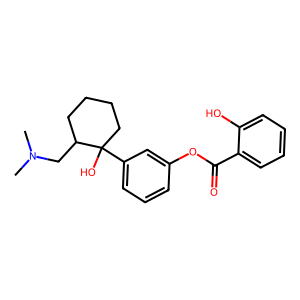

In [9]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [10]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                          [C1CCCCC1, c1ccccc1, c1ccccc1]
1                           [c1cnoc1, c1ccccc1, C1CCCCC1]
2                            [O=C1NC(=O)C2CC12, c1ccccc1]
3                                              [c1ccccc1]
4       [c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...
                              ...                        
8231                                           [c1ccccc1]
8232                   [C1COCO1, O=c1nccc[nH]1, c1ccccc1]
8233                           [c1ccc2c(c1)ncc1nc[nH]c12]
8234    [c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...
8235    [c1ccc2[nH]ccc2c1, c1ccncc1, C1CCCC1, C1CCC1, ...
Name: ring_sytems, Length: 8236, dtype: object

In [11]:
df.ring_sytems.values

array([list(['C1CCCCC1', 'c1ccccc1', 'c1ccccc1']),
       list(['c1cnoc1', 'c1ccccc1', 'C1CCCCC1']),
       list(['O=C1NC(=O)C2CC12', 'c1ccccc1']), ...,
       list(['c1ccc2c(c1)ncc1nc[nH]c12']),
       list(['c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@@]21C[C@H]43']),
       list(['c1ccc2[nH]ccc2c1', 'c1ccncc1', 'C1CCCC1', 'C1CCC1', 'c1ccccc1'])],
      dtype=object)

See how many times each ring system occurs

In [12]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
1,c1ccccc1,6379
21,c1ccncc1,814
30,C1CCNCC1,604
51,C1CNCCN1,481
67,C1CCOCC1,345
...,...,...
1671,c1cnc2c(c1)NCC2,1
1672,O=C1CCCCCc2cc(ccn2)-c2[nH]ncc2N1,1
1673,c1ncc2occc2n1,1
1674,c1cnc2c(c1)CCN2,1


View the ring system frequencies

In [13]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [14]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [15]:
res

0       [(C1CCCCC1, 77480), (c1ccccc1, 2260082), (c1cc...
1       [(c1cnoc1, 28864), (c1ccccc1, 2260082), (C1CCC...
2           [(O=C1NC(=O)C2CC12, 43), (c1ccccc1, 2260082)]
3                                   [(c1ccccc1, 2260082)]
4       [(c1ccc2[nH]ccc2c1, 93446), (C1=C[C@H]2CC[C@@H...
                              ...                        
8231                                [(c1ccccc1, 2260082)]
8232    [(C1COCO1, 2415), (O=c1nccc[nH]1, 5676), (c1cc...
8233                    [(c1ccc2c(c1)ncc1nc[nH]c12, 538)]
8234    [(c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[...
8235    [(c1ccc2[nH]ccc2c1, 93446), (c1ccncc1, 231698)...
Name: mol, Length: 8236, dtype: object

In [16]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80
...,...,...,...,...,...,...
8231,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082
8232,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCC[C@H](C)OC(=O)[C@H](C)NP(=O)(OC[C@H]1OC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72ce0>,"[C1COCO1, O=c1nccc[nH]1, c1ccccc1]",C1COCO1,2415
8233,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538
8234,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0


In [17]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [18]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Proton(s) added/removed

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Proton(s) added/removed

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Charges were rearranged

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Proton(s) added/removed

[15:11:07] WARNING: Omitted undefined stereo

[15:11:07] WARNING: Proton(s) added/removed

[15:11:07] WARNING: Omitted undefined s

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80,InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...
...,...,...,...,...,...,...,...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1..."
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...
7698,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0,InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...


How many of them have ring system?

In [19]:
df_ring = df[df.min_freq != -1]
df_ring

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80,InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...
...,...,...,...,...,...,...,...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1..."
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...
7698,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0,InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...


In [20]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...
5,/home/yang2531/Documents/Bo_toolbox/PatWalters...,C/C(=C(\CCOC(=O)c1ccccc1)SS/C(CCOC(=O)c1ccccc1...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790350>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1cncnc1]",c1cncnc1,81465,InChI=1S/C38H42N8O6S2/c1-25(45(23-47)21-31-19-...
6,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(=O)[C@@]1(Br)CC[C@H]2[C@@H]3C[C@H](F)C4=CC(...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7903c0>,[O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H...,O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]...,494,InChI=1S/C21H28BrFO2/c1-12(24)21(22)9-6-16-14-...
...,...,...,...,...,...,...,...
7693,/home/yang2531/Documents/Bo_toolbox/PatWalters...,NC(=O)NC[C@@H]1CCCc2cc(S(=O)(=O)c3cccc(F)c3)ccc21,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72b20>,"[c1ccc2c(c1)CCCC2, c1ccccc1]",c1ccc2c(c1)CCCC2,8799,InChI=1S/C18H19FN2O3S/c19-14-5-2-6-15(10-14)25...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1..."
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...


### How many of them could pass PAINS filter?

Get a list of rules

In [21]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [22]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [23]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [24]:
reos.pandas_mols(df.mol)

  0%|          | 0/7700 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
7695,ok,ok
7696,ok,ok
7697,ok,ok
7698,ok,ok


In [25]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/7700 [00:00<?, ?it/s]

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...,ok,ok
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...,ok,ok
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...,ok,ok
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...,ok,ok
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80,InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...,ok,ok
...,...,...,...,...,...,...,...,...,...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...,ok,ok
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1...",ok,ok
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...,ok,ok
7698,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0,InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...,ok,ok


### How many of them could pass filters suggested by Dr.Reymond?

In [26]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...,True
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...,True
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...,True
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...,True
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80,InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...,True
...,...,...,...,...,...,...,...,...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...,True
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1...",True
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...,True
7698,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0,InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...,True


In [27]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...,True
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...,True
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...,True
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...,True
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80,InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...,True
...,...,...,...,...,...,...,...,...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...,True
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1...",True
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...,True
7698,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0,InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...,True


### How many of them could pass RO5?

In [28]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

[15:12:04] WARNING: not removing hydrogen atom without neighbors
[15:12:04] WARNING: not removing hydrogen atom without neighbors
[15:12:04] WARNING: not removing hydrogen atom without neighbors
[15:12:06] WARNING: not removing hydrogen atom without neighbors


,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...,True,True
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...,True,True
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...,True,True
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...,True,True
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCOC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@]1(O...,<rdkit.Chem.rdchem.Mol object at 0x7c303a7902e0>,"[c1ccc2[nH]ccc2c1, C1=C[C@H]2CC[C@@H]3Nc4ccccc...",c1ccc2c3c([nH]c2c1)CC[C@@H]1CCCN(CC3)C1,80,InChI=1S/C56H68N6O9/c1-7-52(67)28-33-29-55(51(...,True,False
...,...,...,...,...,...,...,...,...,...
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...,True,True
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1...",True,True
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...,True,True
7698,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC[C@H]1[C@@H]2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]4...,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72dc0>,[c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C...,c1ccc2c(c1)N[C@H]1[C@@H]3C[C@H]4CCN3[C@H]3C[C@...,0,InChI=1S/C20H26N2O2/c1-3-10-11-8-14-17-20(12-6...,True,True


In [29]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CC1CCCCC1(O)c1cccc(OC(=O)c2ccccc2O)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790120>,"[C1CCCCC1, c1ccccc1, c1ccccc1]",C1CCCCC1,77480,InChI=1S/C22H27NO4/c1-23(2)15-17-8-5-6-13-22(1...,True,True
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)c...,<rdkit.Chem.rdchem.Mol object at 0x7c303a790190>,"[c1cnoc1, c1ccccc1, C1CCCCC1]",c1cnoc1,28864,InChI=1S/C20H26N4O5S/c1-14-13-18(23-29-14)19(2...,True,True
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C1NC(=O)C2(c3ccc(Cl)cc3)CC12,<rdkit.Chem.rdchem.Mol object at 0x7c303a790200>,"[O=C1NC(=O)C2CC12, c1ccccc1]",O=C1NC(=O)C2CC12,43,InChI=1S/C11H8ClNO2/c12-7-3-1-6(2-4-7)11-5-8(1...,True,True
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)C(=O)Oc1cc(OC(=O)C(C)C)cc(C(O)CNC(C)(C)C)c1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790270>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C20H31NO5/c1-12(2)18(23)25-15-8-14(17...,True,True
7,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=C(O)CCCCc1ccc(CCCc2ccccc2)s1,<rdkit.Chem.rdchem.Mol object at 0x7c303a790430>,"[c1ccsc1, c1ccccc1]",c1ccsc1,68146,InChI=1S/C18H22O2S/c19-18(20)12-5-4-10-16-13-1...,True,True
...,...,...,...,...,...,...,...,...,...
7694,/home/yang2531/Documents/Bo_toolbox/PatWalters...,O=[Se](=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72b90>,[],,-1,"InChI=1S/H2O4Se/c1-5(2,3)4/h(H2,1,2,3,4)",True,True
7695,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)Cc1ccc([C@@H](C)C(=O)NS(C)(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c00>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C14H21NO3S/c1-10(2)9-12-5-7-13(8-6-12...,True,True
7696,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)(C)NCC(O)COc1cc(Cl)ccc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72c70>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C13H19Cl2NO2/c1-13(2,3)16-7-10(17)8-1...",True,True
7697,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCc1nc2c(N)nc3ccccc3c2n1CCCCNS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7c3037d72d50>,[c1ccc2c(c1)ncc1nc[nH]c12],c1ccc2c(c1)ncc1nc[nH]c12,538,InChI=1S/C17H23N5O2S/c1-3-14-21-15-16(12-8-4-5...,True,True


### Check the properties of generated compounds

The aim is to see if we could find specific charateristics of each algorithm

Calculate the molecular weight and then visualize the distribution:

[15:12:07] WARNING: not removing hydrogen atom without neighbors
[15:12:07] WARNING: not removing hydrogen atom without neighbors
[15:12:07] WARNING: not removing hydrogen atom without neighbors
[15:12:08] WARNING: not removing hydrogen atom without neighbors


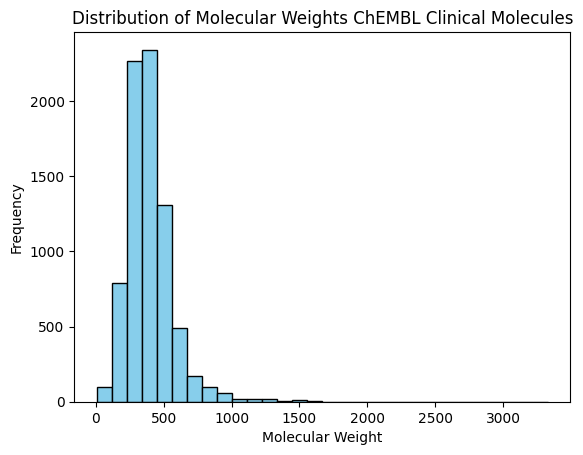

In [30]:
def calculate_molecular_weights(smiles_list):
    """Calculate molecular weights for a list of SMILES strings."""
    molecular_weights = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            molecular_weights.append(mw)
    return molecular_weights

def plot_molecular_weight_distribution(molecular_weights, bins=30):
    """Plot the distribution of molecular weights as a histogram."""
    plt.hist(molecular_weights, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Molecular Weights ChEMBL Clinical Molecules")
    plt.xlabel("Molecular Weight")
    plt.ylabel("Frequency")
    plt.show()
    
molecular_weights = calculate_molecular_weights(df.SMILES.tolist())
plot_molecular_weight_distribution(molecular_weights)

Number of heavy atoms:

[15:12:08] WARNING: not removing hydrogen atom without neighbors
[15:12:08] WARNING: not removing hydrogen atom without neighbors
[15:12:08] WARNING: not removing hydrogen atom without neighbors
[15:12:09] WARNING: not removing hydrogen atom without neighbors


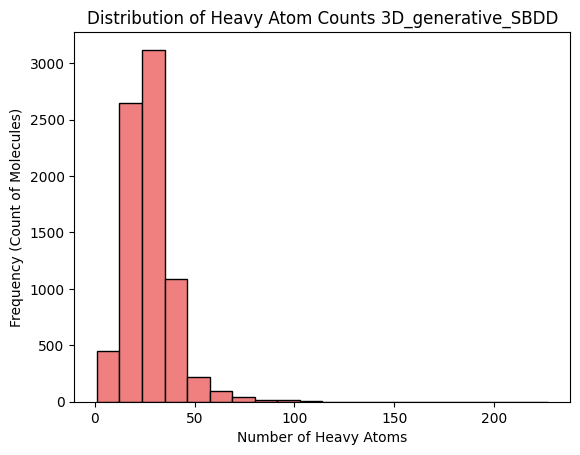

In [31]:
def calculate_heavy_atom_counts(smiles_list):
    """Calculate heavy atom counts for a list of SMILES strings."""
    heavy_atom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            heavy_atom_count = mol.GetNumHeavyAtoms()
            heavy_atom_counts.append(heavy_atom_count)
    return heavy_atom_counts

def plot_heavy_atom_distribution(heavy_atom_counts, bins=20):
    """Plot the distribution of heavy atom counts as a histogram with frequency on the y-axis."""
    plt.hist(heavy_atom_counts, bins=bins, color='lightcoral', edgecolor='black', density=False)
    plt.title("Distribution of Heavy Atom Counts 3D_generative_SBDD")
    plt.xlabel("Number of Heavy Atoms")
    plt.ylabel("Frequency (Count of Molecules)")
    plt.show()
    
heavy_atom_counts = calculate_heavy_atom_counts(df.SMILES.tolist())
plot_heavy_atom_distribution(heavy_atom_counts)

Number of hetero atoms:

[15:12:10] WARNING: not removing hydrogen atom without neighbors
[15:12:10] WARNING: not removing hydrogen atom without neighbors
[15:12:10] WARNING: not removing hydrogen atom without neighbors
[15:12:10] WARNING: not removing hydrogen atom without neighbors


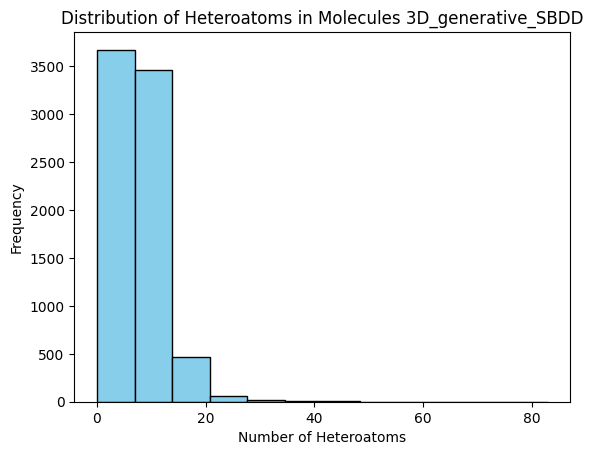

In [32]:
def calculate_heteroatom_counts(smiles_list):
    """Calculate the number of heteroatoms for each SMILES string in the list."""
    heteroatom_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count atoms that are not C or H
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            heteroatom_counts.append(heteroatom_count)
    return heteroatom_counts

def plot_heteroatom_distribution(heteroatom_counts, bins=12):
    """Plot the distribution of heteroatom counts as a histogram with frequency on the y-axis."""
    plt.hist(heteroatom_counts, bins=bins, color='skyblue', edgecolor='black', density=False)
    plt.xlabel("Number of Heteroatoms")
    plt.ylabel("Frequency")
    plt.title("Distribution of Heteroatoms in Molecules 3D_generative_SBDD")
    plt.show()

heteroatom_counts = calculate_heteroatom_counts(df.SMILES.tolist())
plot_heteroatom_distribution(heteroatom_counts)

Ratio of hetero atoms over heavy atoms:

[15:12:11] WARNING: not removing hydrogen atom without neighbors
[15:12:11] WARNING: not removing hydrogen atom without neighbors
[15:12:11] WARNING: not removing hydrogen atom without neighbors
[15:12:12] WARNING: not removing hydrogen atom without neighbors


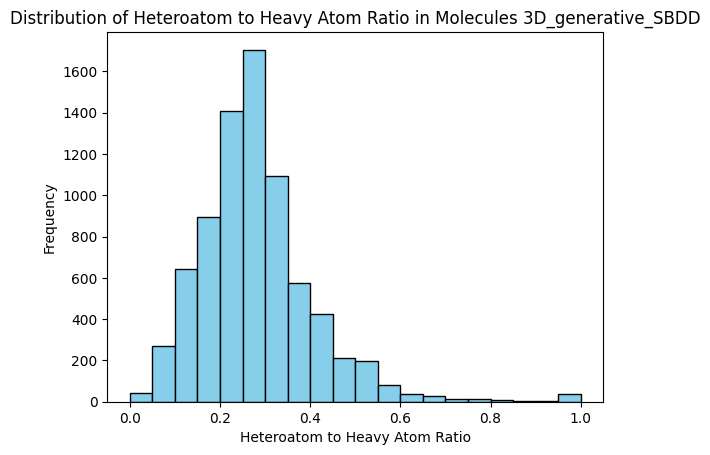

In [33]:
def calculate_heteroatom_ratio(smiles_list):
    """Calculate the ratio of heteroatoms to heavy atoms for each molecule in the SMILES list."""
    heteroatom_ratios = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Count heavy atoms (all atoms except hydrogen)
            heavy_atom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1)
            # Count heteroatoms (atoms other than C and H)
            heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in {1, 6})
            # Calculate ratio if heavy_atom_count is non-zero
            if heavy_atom_count > 0:
                ratio = heteroatom_count / heavy_atom_count
                heteroatom_ratios.append(ratio)
    return heteroatom_ratios

def plot_heteroatom_ratio_distribution(heteroatom_ratios, bins=20):
    """Plot the distribution of heteroatom-to-heavy atom ratios as a histogram with frequency on the y-axis."""
    plt.hist(heteroatom_ratios, bins=bins, color='skyblue', edgecolor='black', density=False)
    plt.xlabel("Heteroatom to Heavy Atom Ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of Heteroatom to Heavy Atom Ratio in Molecules 3D_generative_SBDD")
    plt.show()
    
heteroatom_ratios = calculate_heteroatom_ratio(df.SMILES.tolist())
plot_heteroatom_ratio_distribution(heteroatom_ratios)